# Profiling report

This notebook processes the profiling records that were generated by `$REPO_ROOT/profiler.sh`,
computes aggregate statistics
and generates plots to be used for further analysis.

Results are exported to `$REPO_ROOT/reports/nb`.

In [1]:
import os
import json
import git
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import datetime
PARENT_DIR_REPORTS = './reports/nb/'
REPORT_TIMESTAMP = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
DIR_REPORT = os.path.join(PARENT_DIR_REPORTS, REPORT_TIMESTAMP)
os.makedirs(DIR_REPORT, exist_ok=True)
DIR_REPORT

'./reports/nb/2023-11-17T00:50:19'

In [2]:
def get_repo_info():    
    repo = git.Repo(path='.')
    return {
        'head': repo.head.commit.__str__(),
        'branch': repo.active_branch.__str__()
    }


## Input data

In [3]:
records = dict(
    map(
        lambda fpath: (fpath, pd.Series(json.loads(open(fpath, 'r').read()), name=fpath)),
        glob('./reports/profiling/*.json')
    )
)
len(records)

200

In [4]:
series = pd.concat(records)
series.index.get_level_values(0).unique().shape
df = series.unstack()
df.index.set_names('fpath',inplace=True)
df.reset_index(inplace=True)
df['actor'] = df.fpath.apply(os.path.basename).str.split('-').apply(lambda x: x[0])
df.index.set_names('idx_report',inplace=True)
df.rename({'start':'start_report','end':'end_report','delta':'delta_report'},axis=1,inplace=True)
display(df.head())
df.shape

,fpath,actor,records,start_report,end_report,delta_report
idx_report,,,,,,
0,./reports/profiling/Bls12381G2VCActor-17001669...,Bls12381G2VCActor,"[{'index': 0, 'name': 'createCredential', 'sta...",1700166923124,1700166927711,4587
1,./reports/profiling/SolidVCActor-1700166362749...,SolidVCActor,"[{'index': 0, 'name': 'createCredential', 'sta...",1700166362749,1700166362883,134
2,./reports/profiling/SolidVCActor-1700164963460...,SolidVCActor,"[{'index': 0, 'name': 'createCredential', 'sta...",1700164963460,1700164963619,159
3,./reports/profiling/Bls12381G2VCActor-17001666...,Bls12381G2VCActor,"[{'index': 0, 'name': 'createCredential', 'sta...",1700166623198,1700166626294,3096
4,./reports/profiling/SolidVCActor-1700165372681...,SolidVCActor,"[{'index': 0, 'name': 'createCredential', 'sta...",1700165372681,1700165372802,121


(200, 6)

## Analysis

In [5]:
AGG_FUNCTIONS = ['mean', 'std', 'min','max','count']

### Actor-level statistics

In [6]:
df_agg_al = df.groupby('actor')['delta_report'].agg(AGG_FUNCTIONS)
df_agg_al

,mean,std,min,max,count
actor,,,,,
Bls12381G2VCActor,3546.78,2225.697914,2938,19215,100
SolidVCActor,127.1,9.774736,110,159,100


Compute & export aggregate statistics

In [7]:
df_agg_al.to_csv(os.path.join(DIR_REPORT, 'df_agg_actor-level.csv'))

### Task-level statistics

In [8]:
# Expand report records into task-level dataframes
df_tl = df.records\
    .apply(pd.Series)\
    .stack()\
    .apply(pd.Series)\
    .rename({'index':'idx_step'},axis=1)\
    .reset_index().drop('level_1',axis=1)\
    .set_index(['idx_report','idx_step'])
# Merge task-level df with initial df
df_tl = df.drop('records',axis=1).merge(df_tl,left_index=True,right_index=True)
display(df_tl.head(3))
df_tl.shape

fpath  \
idx_report idx_step                                                      
0          0         ./reports/profiling/Bls12381G2VCActor-17001669...   
           1         ./reports/profiling/Bls12381G2VCActor-17001669...   
           2         ./reports/profiling/Bls12381G2VCActor-17001669...   

                                 actor   start_report     end_report  \
idx_report idx_step                                                    
0          0         Bls12381G2VCActor  1700166923124  1700166927711   
           1         Bls12381G2VCActor  1700166923124  1700166927711   
           2         Bls12381G2VCActor  1700166923124  1700166927711   

                    delta_report                        name          start  \
idx_report idx_step                                                           
0          0                4587            createCredential  1700166923124   
           1                4587  createVerifiableCredential  1700166923124   
           2                4587           createJSONLDFrame  1700166923150   

                               end  delta  
idx_report idx_step                        
0          0         1700166923124      0  
           1         1700166923150     26  
           2         1700166923150      0

(1400, 9)

Compute & export aggregate statistics

In [9]:
# name refers to the function/step name
df_tl_agg = df_tl.groupby(['actor','name'])['delta'].agg(AGG_FUNCTIONS)
df_tl_agg.to_csv(os.path.join(DIR_REPORT, 'df_agg_task-level.csv'))

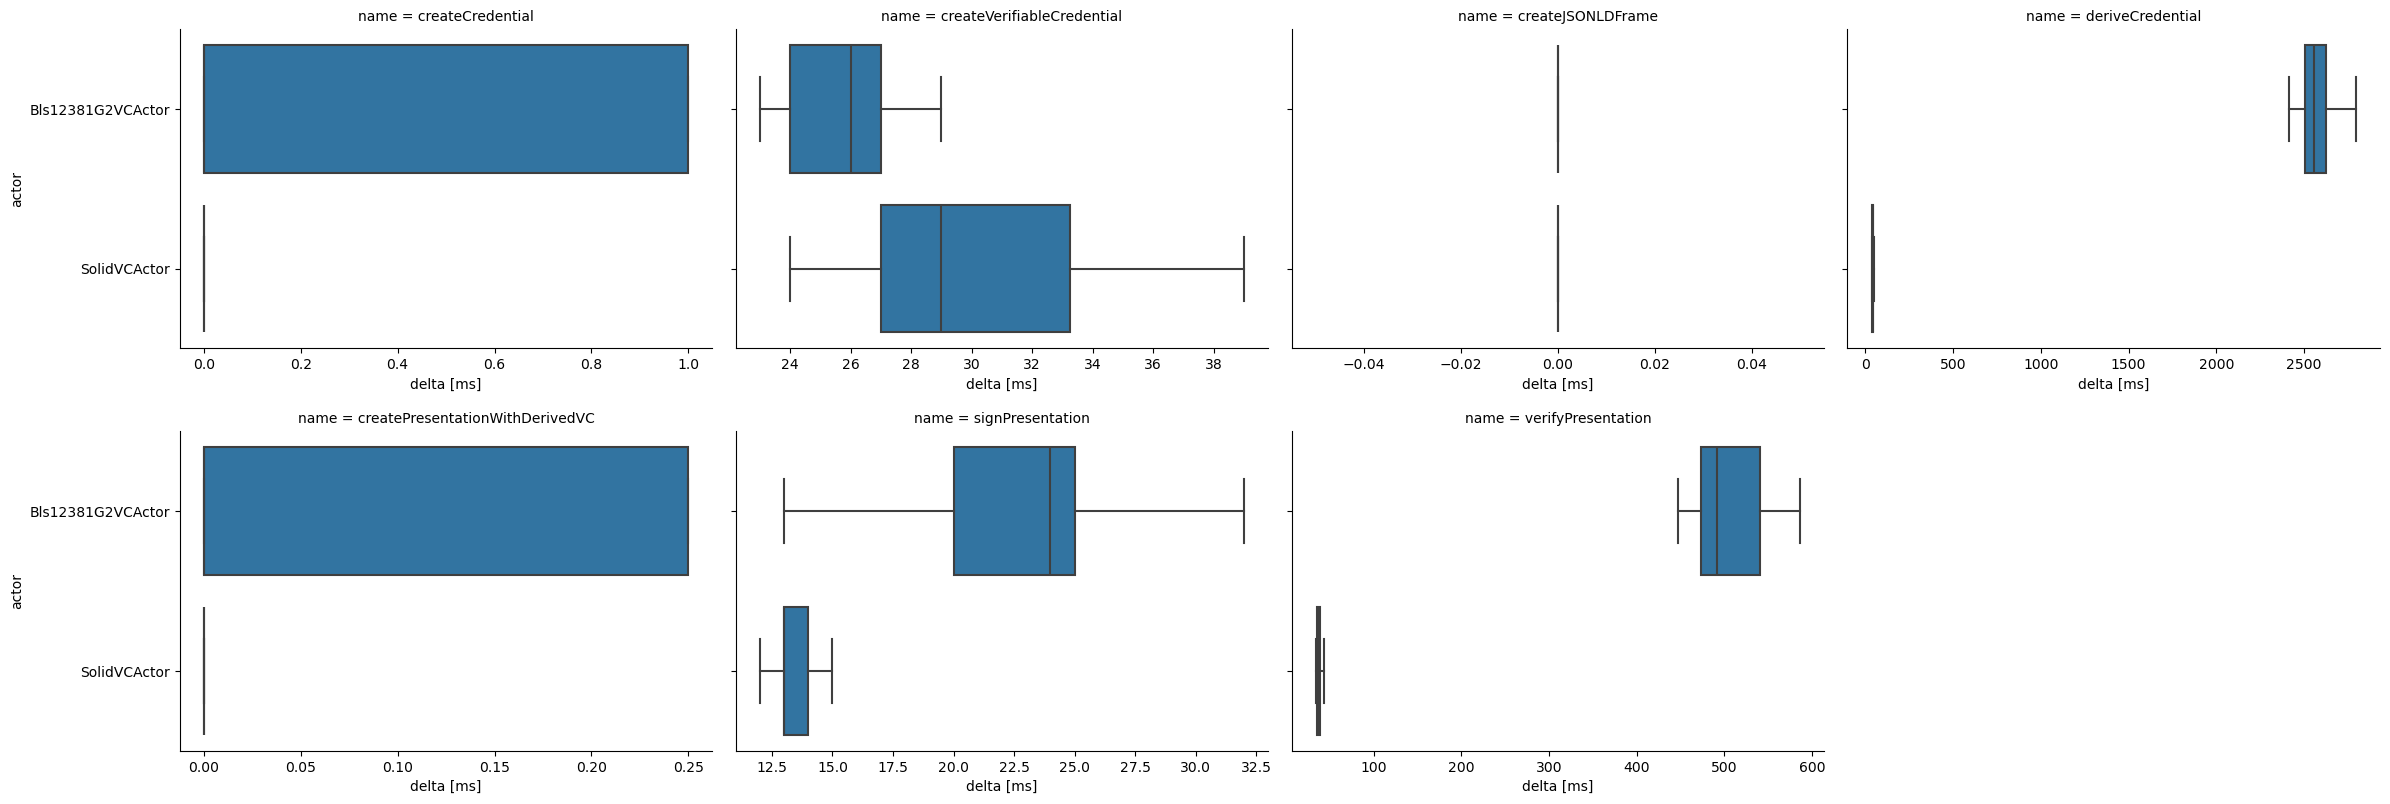

In [10]:
kwargs_fg = dict(col = 'name',  col_wrap=4, sharey=True,sharex=False,aspect=2)
kwargs_plot = dict(
    x='delta',
    y='actor',
    orient='h',
    showfliers=False,
)
g = sns.FacetGrid(**kwargs_fg, data=df_tl)
g.map_dataframe(sns.boxplot, **kwargs_plot)
g.tight_layout()
g.fig.subplots_adjust(top=1.3)

for ax in g.axes.ravel():
    ax.set_xlabel('{} [ms]'.format(kwargs_plot['x']))
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    pass

plt.savefig(os.path.join(DIR_REPORT,'boxplot-actor-on-delta-per-step.png'))
plt.show()

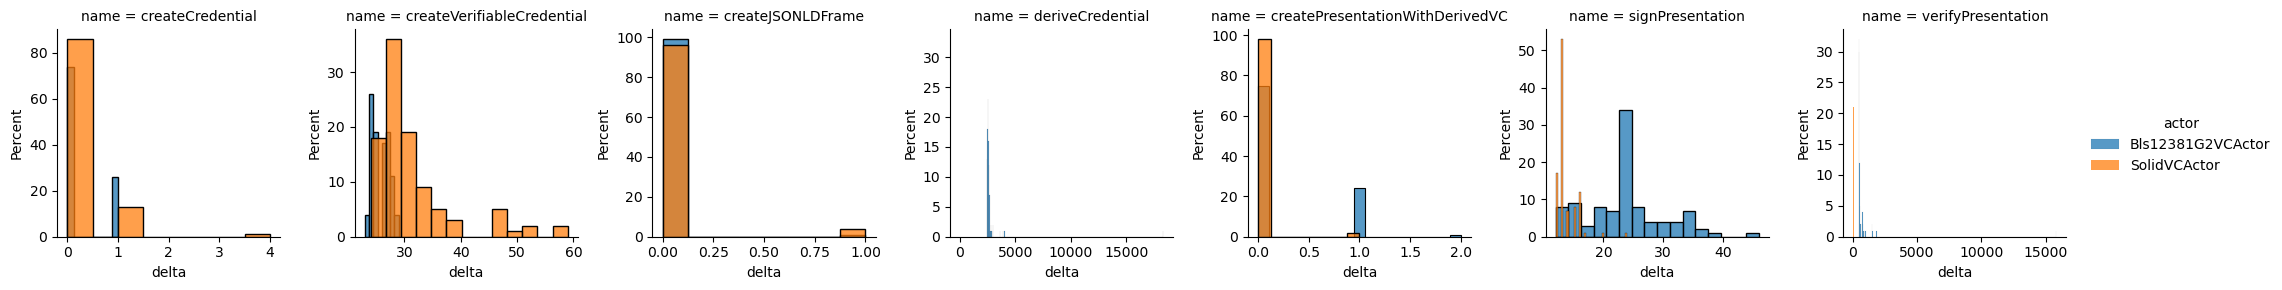

In [11]:
kwargs_fg = dict(col = 'name',  col_wrap=None, sharey=False,sharex=False, legend_out=True,    hue='actor',)
kwargs_plot = dict(
    x='delta',
    stat='percent',
    element='bars',
    discrete=False,
#    common_norm=True

)
g = sns.FacetGrid(**kwargs_fg, data=df_tl)
g = g.map_dataframe(sns.histplot, **kwargs_plot)
for ax in g.axes.ravel():
    pass

g.add_legend()
plt.savefig(os.path.join(DIR_REPORT,'barplot-actor-on-percentage-delta-per-step.png'))
plt.show()

In [12]:
get_repo_info()
json.dump(get_repo_info(), open(os.path.join(DIR_REPORT,'repo-info.json'), 'w'))